# Задача по определению вероятности возврата денег в таверну 

Описание кейса

Вернемся к гномам - исследователям в сфере Машинного Обучения! 

Гномы достаточно дружные, искренние и доверчивые существа и живут общинами. В каждом поселении есть таверна, в которой разливают вкусный эль и пекут замечательные булочки. Не смотря на все свои светлые качества, гномы достаточно забывчивые и расторопные, поэтому после завершения домашних дел перед ужином в таверне забывают кошелек, а расплачиваются утром на следующий день.

Особо нечестные жители общины могут и вовсе не вернуть деньги заведению, поэтому любители гномьего Машинного Обучения предложили следующую идею: научиться предсказывать, вернет ли забывший дома кошелек гном деньги в течение ближайших дней или, на современном языке, его заказ дефолтнет. Это позволит повысить финансовую стабильность таверны, не исполняя заказы, которые заранее не будут оплачены.

Ваша задача - построить алгоритм, определяющий вероятность дефолта того или иного заказа на исторических данных из таверн различных гномьих общин с 2015-02-24 по 2016-09-30.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('data/train.csv')

train.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


In [3]:
test = pd.read_csv('data/test.csv')

test.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender
0,72875713,2016-10-14,2015-09-20,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,7,2.5,-3,18,2.5,-3,5,40.0,Female
1,75825544,2016-10-23,2015-06-16,NaN,NaN,NaN,NaN,6.0,Tavern_district_3,18,2.5,-2,15,3.5,-3,5,66.0,Female
2,81809181,2016-11-17,2016-09-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,7,2.5,-3,5,36.0,Female
3,87083256,2016-12-26,2016-06-25,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,7,2.5,-2,6,2.5,2,5,32.0,Female
4,84651519,2016-12-07,2016-10-15,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,6,2.5,-3,5,37.0,Female


In [4]:
train

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,42976693,2016-04-09,2015-11-07,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,10,2.5,-3,5,37.0,Female,0
3164,50503195,2016-05-23,2015-12-17,NaN,NaN,NaN,NaN,0.0,Tavern_district_5,7,2.5,-3,10,2.5,-3,5,31.0,Female,0
3165,66034984,2016-09-14,2016-08-15,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,7,2.5,-3,5,3.5,-3,5,26.0,Male,1
3166,65042945,2016-09-09,2016-03-14,NaN,NaN,NaN,NaN,0.0,Tavern_district_7,7,2.5,-3,11,2.5,-3,5,28.0,Female,0


In [5]:
train.count()

Deal_id                   3168
Deal_date                 3168
First_deal_date           3168
Secret_dwarf_info_1        535
Secret_dwarf_info_2        535
Secret_dwarf_info_3        535
First_default_date         535
Successful_deals_count    3154
Region                    3161
Tavern                    3168
Hashed_deal_detail_1      3168
Hashed_deal_detail_2      3168
Hashed_deal_detail_3      3168
Hashed_deal_detail_4      3168
Hashed_deal_detail_5      3168
Hashed_deal_detail_6      3168
Age                       3168
Gender                    3168
Default                   3168
dtype: int64

In [6]:
train['Secret_dwarf_info_1'].unique()

array([nan, 3.5, 4.5, 5.5, 6.5, 8.5, 2.5, 7.5, 9.5])

In [7]:
train['Secret_dwarf_info_2'].unique()

array([nan, -2., -3., -1.,  2.,  0.,  1.])

In [8]:
train['Secret_dwarf_info_3'].unique()

array([nan,  5.,  6.,  7.,  8.])

In [9]:
train['Secret_dwarf_info_1'].value_counts()

3.5    384
4.5     89
5.5     39
6.5     11
2.5      4
7.5      4
8.5      3
9.5      1
Name: Secret_dwarf_info_1, dtype: int64

In [10]:
train['Secret_dwarf_info_2'].value_counts()

-2.0    243
-3.0    232
-1.0     51
 0.0      7
 2.0      1
 1.0      1
Name: Secret_dwarf_info_2, dtype: int64

In [11]:
train['Secret_dwarf_info_3'].value_counts()

5.0    405
6.0    118
7.0     11
8.0      1
Name: Secret_dwarf_info_3, dtype: int64

In [12]:
train[['Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3']].corr()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3
Secret_dwarf_info_1,1.000000,0.426617,0.176354
Secret_dwarf_info_2,0.426617,1.000000,0.525387
Secret_dwarf_info_3,0.176354,0.525387,1.000000


In [13]:
train['Successful_deals_count'].value_counts()

0.0     1903
2.0      592
3.0      244
1.0      194
4.0      105
5.0       52
6.0       23
7.0       13
8.0        9
9.0        8
10.0       6
17.0       2
12.0       2
11.0       1
Name: Successful_deals_count, dtype: int64

In [14]:
train['First_default_date'].value_counts()

2016-01-15    57
2016-04-30    20
2016-01-22    15
2015-12-13    15
2016-01-30    15
              ..
2015-06-10     1
2016-07-18     1
2016-06-14     1
2015-08-10     1
2016-08-06     1
Name: First_default_date, Length: 68, dtype: int64

In [15]:
train['Deal_id'].value_counts()

22487461    1
39644942    1
45023366    1
64198852    1
49172346    1
           ..
28269812    1
1423346     1
56147545    1
66851769    1
66866386    1
Name: Deal_id, Length: 3168, dtype: int64

In [16]:
# создаем фичу 'Dwarf_id'
unique_dwarves = train[['First_deal_date', 'Gender']].drop_duplicates()
unique_dwarves["Dwarf_id"] = unique_dwarves.reset_index().index
train = train.merge(unique_dwarves, on=['First_deal_date', 'Gender'])
# train = train.drop(['First_deal_date', 'Gender'], axis=1)

In [17]:
test = test.merge(unique_dwarves, on=['First_deal_date', 'Gender'], how='left')
test['Dwarf_id'] = test['Dwarf_id'].fillna(1000)
# test = test.drop(['First_deal_date', 'Gender'], axis=1)

In [18]:
unique_dwarves

,First_deal_date,Gender,Dwarf_id
0,2015-08-29,Male,0
1,2015-12-21,Female,1
2,2015-11-11,Female,2
3,2016-03-22,Female,3
4,2016-07-21,Female,4
...,...,...,...
3062,2015-08-12,Male,811
3067,2016-04-24,Male,812
3101,2016-01-27,Female,813
3165,2016-08-15,Male,814


In [19]:
def tranformer(df):
    df_c = df.copy()
    # приводим к категориальным признакам
    features_to_str = [
        'Hashed_deal_detail_1',
        'Hashed_deal_detail_2',
        'Hashed_deal_detail_3',
        'Hashed_deal_detail_4',
        'Hashed_deal_detail_5',
    ]
    df_c[features_to_str] = df_c[features_to_str].astype(str)
    
    # unique = array([5])
    df_c = df_c.drop('Hashed_deal_detail_6', axis=1)
    
#     df_c['Had default'] = df_c['First_default_date'].notnull().astype(int)
    
#     df_c = df_c.join(pd.get_dummies(df_c['Gender'], drop_first=True))
#     df_c = df_c.drop('Gender', axis=1)

#     df_c = df_c.join(pd.get_dummies(df_c['Hashed_deal_detail_1'], prefix=['detail_1'], drop_first=True))
#     df_c = df_c.drop('Hashed_deal_detail_1', axis=1)
    
#     df_c = df_c.join(pd.get_dummies(df_c['Hashed_deal_detail_2'], prefix=['detail_2'], drop_first=True))
#     df_c = df_c.drop('Hashed_deal_detail_2', axis=1)
    
#     df_c = df_c.join(pd.get_dummies(df_c['Hashed_deal_detail_3'], prefix=['detail_3'], drop_first=True))
#     df_c = df_c.drop('Hashed_deal_detail_3', axis=1)
    
#     df_c = df_c.join(pd.get_dummies(df_c['Hashed_deal_detail_4'], prefix=['detail_4'], drop_first=True))
#     df_c = df_c.drop('Hashed_deal_detail_4', axis=1)
    
#     df_c = df_c.join(pd.get_dummies(df_c['Hashed_deal_detail_5'], prefix=['detail_5'], drop_first=True))
#     df_c = df_c.drop('Hashed_deal_detail_5', axis=1)

    # меняем пол на цифры: 1 или  0
    df_c['Gender'] = df_c['Gender'].map({'Male': 1, 'Female': 0})
    
    # меняем название региона на числое, которое он обозначает
    df_c['Region'] = df_c['Region'].map({
        'Tavern_district_0': '0',
        'Tavern_district_1': '1',
        'Tavern_district_2': '2',
        'Tavern_district_3': '3',
        'Tavern_district_4': '4',
        'Tavern_district_5': '5',
        'Tavern_district_6': '6',
        'Tavern_district_7': '7',
    })

#     df_c = df_c.join(pd.get_dummies(df_c['Region'], prefix='Region', drop_first=True))
#     df_c = df_c.drop('Region', axis=1)
    
    # заполняем далеком значением, чтобы отличать от гномов, которое дефолтили
    df_c['First_default_date'] = df_c['First_default_date'].fillna(-1)
    
    df_c['First_deal_date'] = pd.to_datetime(df_c['First_deal_date'])
    df_c['First_default_date'] = pd.to_datetime(df_c['First_default_date'])
    df_c['Deal_date'] = pd.to_datetime(df_c['Deal_date'])
    
#     df_c['Days_to_first_default'] = (df_c['First_default_date'] - df_c['First_deal_date']).dt.days
    
    # создаем фичи: день недели, месяц, год, день месяца
    
    df_c['Deal_day_of_week'] = df_c['Deal_date'].dt.dayofweek
    df_c['Deal_month'] = df_c['Deal_date'].dt.month
    df_c['Deal_year'] =  df_c['Deal_date'].dt.year
    df_c['Deal_day'] =  df_c['Deal_date'].dt.day
    df_c = df_c.drop('Deal_date', axis=1)
    
    df_c['First_deal_day_of_week'] = df_c['First_deal_date'].dt.dayofweek
    df_c['First_deal_month'] = df_c['First_deal_date'].dt.month
    df_c['First_deal_year'] =  df_c['First_deal_date'].dt.year
    df_c['First_deal_day'] =  df_c['First_deal_date'].dt.day
    df_c = df_c.drop('First_deal_date', axis=1)
    
    df_c['First_default_day_of_week'] = df_c['First_default_date'].dt.dayofweek
    df_c['First_default_month'] = df_c['First_default_date'].dt.month
    df_c['First_default_year'] =  df_c['First_default_date'].dt.year
    df_c['First_default_day'] =  df_c['First_default_date'].dt.day
    df_c = df_c.drop('First_default_date', axis=1)
    
#     df_c.loc[0, 'Secret_dwarf_info_1'] = df_c['Secret_dwarf_info_1'].mean()
#     df_c.loc[0, 'Secret_dwarf_info_2'] = df_c['Secret_dwarf_info_2'].mean()
#     df_c.loc[0, 'Secret_dwarf_info_3'] = df_c['Secret_dwarf_info_3'].mean()
    
#     for i in range(1, len(df_c)):
#         if pd.isna(df_c.loc[i, 'Secret_dwarf_info_1']):
#             df_c.loc[i, 'Secret_dwarf_info_1'] = df_c.loc[i - 1, 'Secret_dwarf_info_1']
#         if pd.isna(df_c.loc[i, 'Secret_dwarf_info_2']):
#             df_c.loc[i, 'Secret_dwarf_info_2'] = df_c.loc[i - 1, 'Secret_dwarf_info_2']
#         if pd.isna(df_c.loc[i, 'Secret_dwarf_info_3']):
#             df_c.loc[i, 'Secret_dwarf_info_3'] = df_c.loc[i - 1, 'Secret_dwarf_info_3']
#     features_to_str = [
#         'First_default_day',
#         'First_default_month',
#         'First_default_year',
#         'First_default_day_of_week',
#         'First_deal_day',
#         'First_deal_month',
#         'First_deal_year',
#         'First_deal_day_of_week',
#         'Deal_day',
#         'Deal_month',
#         'Deal_year',
#         'Deal_day_of_week'
#     ]
#     df_c[features_to_str] = df_c[features_to_str].astype(str)
    

    # заполняем пропуски средним арифметическим
    df_c['Secret_dwarf_info_1'] = df_c['Secret_dwarf_info_1'].fillna(train['Secret_dwarf_info_1'].mean())
    df_c['Secret_dwarf_info_2'] = df_c['Secret_dwarf_info_2'].fillna(train['Secret_dwarf_info_2'].mean())
    df_c['Secret_dwarf_info_3'] = df_c['Secret_dwarf_info_3'].fillna(train['Secret_dwarf_info_3'].mean())
    
#     df_c['First_default_day_of_week'] = df_c['First_default_day_of_week'].fillna(np.random.randint(5, 8))
#     df_c['First_default_month'] = df_c['First_default_month'].fillna(df_c['First_default_month'].mean(),)
#     df_c['First_default_year'] = df_c['First_default_year'].fillna(np.random.randint(2015, 2017))

    # заполняем пропуски нулями, потому что не было сделок вообще
    df_c['Successful_deals_count'] = df_c['Successful_deals_count'].fillna(0)
    
#     df_c['Days_to_first_default'] = df_c['Days_to_first_default'].fillna(df_c['Days_to_first_default'].mean())
    
    # заполняем самым популярным районом
    df_c['Region'] = df_c['Region'].fillna(df_c['Region'].mode()[0])
    
    return df_c

In [20]:
train = tranformer(train)
test = tranformer(test)

MTE for Tavern, Gender and Age

In [21]:
means = train.groupby('Tavern')['Default'].mean()
train['Tavern'] = train['Tavern'].map(means)

means = train.groupby('Gender')['Default'].mean()
train['Gender'] = train['Gender'].map(means)

means = train.groupby('Region')['Default'].mean()
train['Region'] = train['Region'].map(means)

means = train.groupby('Age')['Default'].mean()
train['Age'] = train['Age'].map(means)

In [22]:
# train['Tavern'] = train['Tavern'].astype(str)
# test['Tavern'] = test['Tavern'].astype(str)

In [23]:
train.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,...,Deal_year,Deal_day,First_deal_day_of_week,First_deal_month,First_deal_year,First_deal_day,First_default_day_of_week,First_default_month,First_default_year,First_default_day
0,22487461,3.935514,-2.299065,5.26729,0.0,0.129645,0.134432,2.5,-3,8,...,2015,5,5,8,2015,29,2,12,1969,31
1,61061755,3.935514,-2.299065,5.26729,3.0,0.129645,0.061417,2.5,-2,15,...,2016,17,5,8,2015,29,2,12,1969,31
2,62494261,3.500000,-2.000000,5.00000,2.0,0.145604,0.134432,2.5,-3,14,...,2016,26,0,12,2015,21,5,7,2016,30
3,49331822,3.935514,-2.299065,5.26729,0.0,0.087866,0.061417,2.5,0,5,...,2016,16,0,12,2015,21,2,12,1969,31
4,48215573,3.500000,-3.000000,5.00000,0.0,0.131455,0.134432,2.5,2,5,...,2016,9,0,12,2015,21,5,2,2016,20


In [24]:
train.count()

Deal_id                      3168
Secret_dwarf_info_1          3168
Secret_dwarf_info_2          3168
Secret_dwarf_info_3          3168
Successful_deals_count       3168
Region                       3168
Tavern                       3168
Hashed_deal_detail_1         3168
Hashed_deal_detail_2         3168
Hashed_deal_detail_3         3168
Hashed_deal_detail_4         3168
Hashed_deal_detail_5         3168
Age                          3168
Gender                       3168
Default                      3168
Dwarf_id                     3168
Deal_day_of_week             3168
Deal_month                   3168
Deal_year                    3168
Deal_day                     3168
First_deal_day_of_week       3168
First_deal_month             3168
First_deal_year              3168
First_deal_day               3168
First_default_day_of_week    3168
First_default_month          3168
First_default_year           3168
First_default_day            3168
dtype: int64

In [25]:
train.dtypes

Deal_id                        int64
Secret_dwarf_info_1          float64
Secret_dwarf_info_2          float64
Secret_dwarf_info_3          float64
Successful_deals_count       float64
Region                       float64
Tavern                       float64
Hashed_deal_detail_1          object
Hashed_deal_detail_2          object
Hashed_deal_detail_3          object
Hashed_deal_detail_4          object
Hashed_deal_detail_5          object
Age                          float64
Gender                       float64
Default                        int64
Dwarf_id                       int64
Deal_day_of_week               int64
Deal_month                     int64
Deal_year                      int64
Deal_day                       int64
First_deal_day_of_week         int64
First_deal_month               int64
First_deal_year                int64
First_deal_day                 int64
First_default_day_of_week      int64
First_default_month            int64
First_default_year             int64
F

<Axes: >

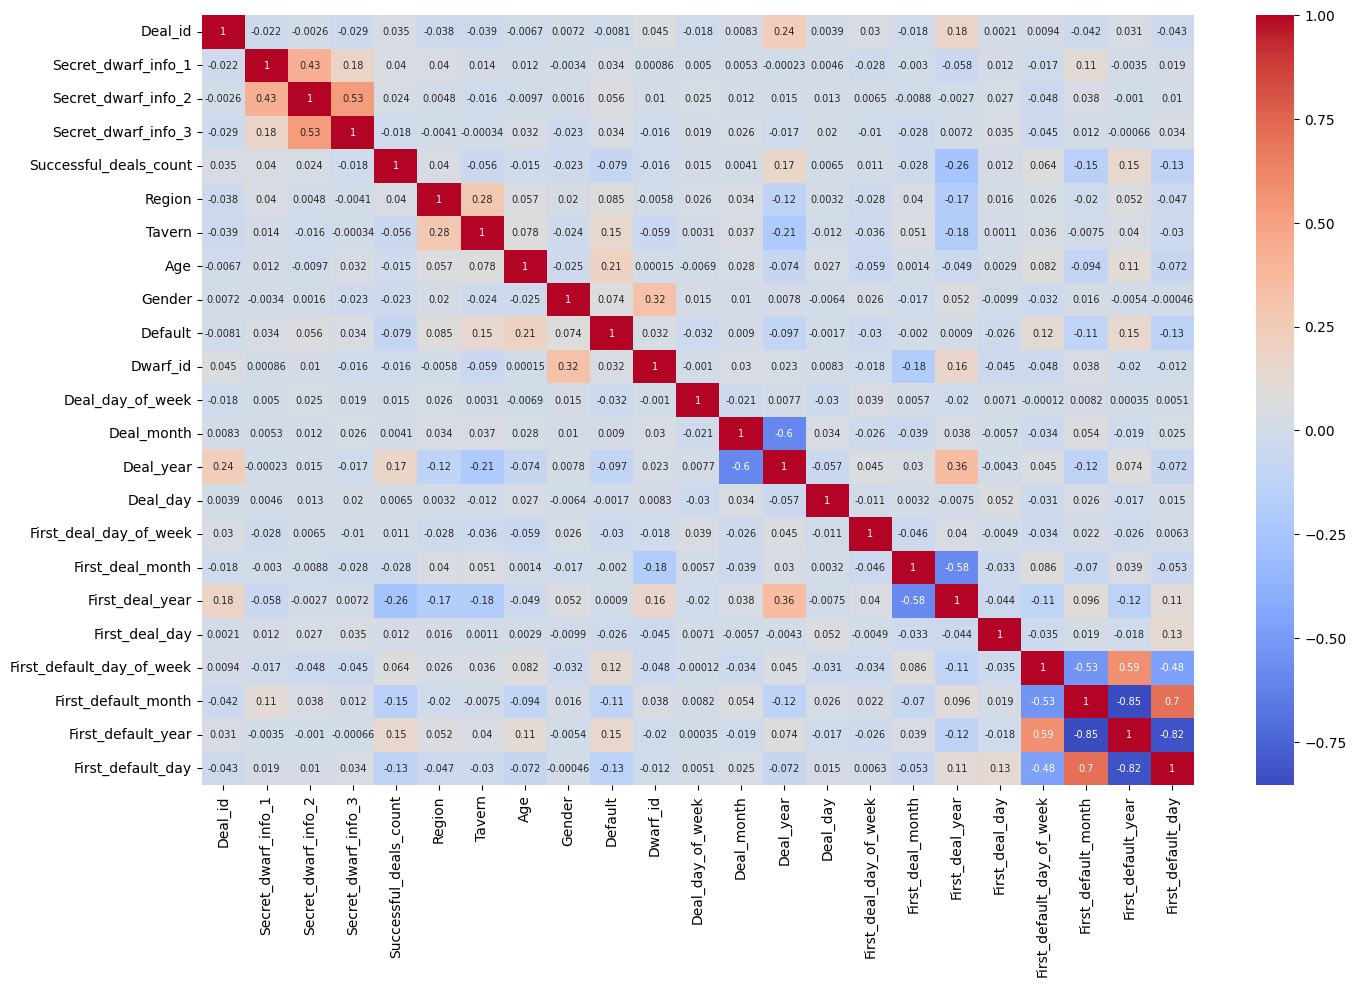

In [26]:
plt.figure(figsize=(16, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 7})

In [41]:
X = train.drop(['Deal_id', 'Default'], axis=1)
y = train['Default']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [43]:
rnf_clf = RandomForestClassifier()

In [44]:
rnf_clf.fit(X, y)

RandomForestClassifier()

In [32]:
result = pd.concat([test['Deal_id'], pd.DataFrame(rnf_clf.predict_proba(test.drop(['Deal_id'], axis=1))[:, 1], columns=['Prediction'])], axis=1)

In [46]:
result.to_csv('models/result_rfc', sep=',')

In [47]:
importance = rnf_clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01226
Feature: 1, Score: 0.01555
Feature: 2, Score: 0.00759
Feature: 3, Score: 0.02776
Feature: 4, Score: 0.05152
Feature: 5, Score: 0.04962
Feature: 6, Score: 0.00134
Feature: 7, Score: 0.01847
Feature: 8, Score: 0.06141
Feature: 9, Score: 0.01739
Feature: 10, Score: 0.00360
Feature: 11, Score: 0.11211
Feature: 12, Score: 0.01611
Feature: 13, Score: 0.10914
Feature: 14, Score: 0.06073
Feature: 15, Score: 0.06558
Feature: 16, Score: 0.01271
Feature: 17, Score: 0.08548
Feature: 18, Score: 0.05448
Feature: 19, Score: 0.06385
Feature: 20, Score: 0.01170
Feature: 21, Score: 0.07955
Feature: 22, Score: 0.01620
Feature: 23, Score: 0.01744
Feature: 24, Score: 0.00827
Feature: 25, Score: 0.02016


In [48]:
rnf_clf.fit(X_train, y_train)

train_pred = rnf_clf.predict(X_train)
test_pred = rnf_clf.predict(X_test)

print(f'roc_auc_score на трейне = {roc_auc_score(y_train, train_pred)}')
print(f'roc_auc_score на тесте = {roc_auc_score(y_test, test_pred)}')

roc_auc_score на трейне = 1.0
roc_auc_score на тесте = 0.5107396149949341


In [49]:
pipeline = Pipeline([('scaler', StandardScaler()),
                    ('rfc', RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_leaf=2,
                                                   min_samples_split=2, n_estimators=200))])

pipeline.fit(X_train, y_train)
result = pd.concat([test['Deal_id'], pd.DataFrame(pipeline.predict_proba(test.drop(['Deal_id'], axis=1))[:, 1], columns=['Prediction'])], axis=1)
result.to_csv('models/result_pipeline', sep=',')

In [50]:
pipeline.fit(X_train, y_train)

train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

print(f'roc_auc_score на трейне = {roc_auc_score(y_train, train_pred)}')
print(f'roc_auc_score на тесте = {roc_auc_score(y_test, test_pred)}')

roc_auc_score на трейне = 0.8540925266903915
roc_auc_score на тесте = 0.5107396149949341


In [51]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(devices='0:1', random_state=1, class_weights = (1, 5))
catboost.fit(X.to_numpy(), y.to_numpy())

Learning rate set to 0.016857
0:	learn: 0.6891745	total: 1.32ms	remaining: 1.32s
1:	learn: 0.6845250	total: 2.3ms	remaining: 1.15s
2:	learn: 0.6803501	total: 3.21ms	remaining: 1.06s
3:	learn: 0.6756483	total: 4.1ms	remaining: 1.02s
4:	learn: 0.6717341	total: 5.03ms	remaining: 1s
5:	learn: 0.6676831	total: 5.99ms	remaining: 992ms
6:	learn: 0.6637580	total: 6.96ms	remaining: 987ms
7:	learn: 0.6599546	total: 8.01ms	remaining: 993ms
8:	learn: 0.6561137	total: 8.93ms	remaining: 983ms
9:	learn: 0.6520510	total: 9.85ms	remaining: 975ms
10:	learn: 0.6495610	total: 10.8ms	remaining: 969ms
11:	learn: 0.6469676	total: 11.7ms	remaining: 964ms
12:	learn: 0.6434108	total: 12.7ms	remaining: 964ms
13:	learn: 0.6407804	total: 13.7ms	remaining: 964ms
14:	learn: 0.6385263	total: 14.8ms	remaining: 971ms
15:	learn: 0.6363306	total: 15.7ms	remaining: 965ms
16:	learn: 0.6338366	total: 16.6ms	remaining: 960ms
17:	learn: 0.6319041	total: 17.5ms	remaining: 957ms
18:	learn: 0.6297643	total: 18.5ms	remaining: 955

196:	learn: 0.4591350	total: 194ms	remaining: 789ms
197:	learn: 0.4586050	total: 195ms	remaining: 789ms
198:	learn: 0.4582972	total: 196ms	remaining: 788ms
199:	learn: 0.4579646	total: 197ms	remaining: 787ms
200:	learn: 0.4576828	total: 198ms	remaining: 786ms
201:	learn: 0.4569975	total: 199ms	remaining: 785ms
202:	learn: 0.4567562	total: 200ms	remaining: 785ms
203:	learn: 0.4559602	total: 201ms	remaining: 784ms
204:	learn: 0.4555268	total: 202ms	remaining: 783ms
205:	learn: 0.4550411	total: 203ms	remaining: 782ms
206:	learn: 0.4548388	total: 204ms	remaining: 781ms
207:	learn: 0.4544608	total: 205ms	remaining: 780ms
208:	learn: 0.4537590	total: 206ms	remaining: 780ms
209:	learn: 0.4535385	total: 207ms	remaining: 780ms
210:	learn: 0.4531048	total: 208ms	remaining: 780ms
211:	learn: 0.4528048	total: 209ms	remaining: 779ms
212:	learn: 0.4523253	total: 210ms	remaining: 777ms
213:	learn: 0.4519455	total: 211ms	remaining: 776ms
214:	learn: 0.4512715	total: 212ms	remaining: 775ms
215:	learn: 

386:	learn: 0.3867813	total: 387ms	remaining: 613ms
387:	learn: 0.3866051	total: 388ms	remaining: 613ms
388:	learn: 0.3864738	total: 389ms	remaining: 612ms
389:	learn: 0.3857414	total: 390ms	remaining: 611ms
390:	learn: 0.3853181	total: 391ms	remaining: 610ms
391:	learn: 0.3849755	total: 393ms	remaining: 609ms
392:	learn: 0.3845529	total: 394ms	remaining: 608ms
393:	learn: 0.3841791	total: 395ms	remaining: 607ms
394:	learn: 0.3835922	total: 396ms	remaining: 606ms
395:	learn: 0.3834117	total: 397ms	remaining: 605ms
396:	learn: 0.3831405	total: 398ms	remaining: 604ms
397:	learn: 0.3829787	total: 399ms	remaining: 603ms
398:	learn: 0.3824719	total: 400ms	remaining: 602ms
399:	learn: 0.3821518	total: 401ms	remaining: 601ms
400:	learn: 0.3816983	total: 402ms	remaining: 600ms
401:	learn: 0.3814276	total: 403ms	remaining: 599ms
402:	learn: 0.3811382	total: 404ms	remaining: 598ms
403:	learn: 0.3808458	total: 405ms	remaining: 597ms
404:	learn: 0.3806841	total: 406ms	remaining: 596ms
405:	learn: 

574:	learn: 0.3183391	total: 581ms	remaining: 430ms
575:	learn: 0.3179226	total: 582ms	remaining: 429ms
576:	learn: 0.3172258	total: 583ms	remaining: 428ms
577:	learn: 0.3168330	total: 585ms	remaining: 427ms
578:	learn: 0.3164303	total: 586ms	remaining: 426ms
579:	learn: 0.3162358	total: 587ms	remaining: 425ms
580:	learn: 0.3157536	total: 588ms	remaining: 424ms
581:	learn: 0.3153939	total: 589ms	remaining: 423ms
582:	learn: 0.3151373	total: 590ms	remaining: 422ms
583:	learn: 0.3147453	total: 591ms	remaining: 421ms
584:	learn: 0.3146014	total: 592ms	remaining: 420ms
585:	learn: 0.3145126	total: 593ms	remaining: 419ms
586:	learn: 0.3142047	total: 594ms	remaining: 418ms
587:	learn: 0.3138317	total: 595ms	remaining: 417ms
588:	learn: 0.3134475	total: 596ms	remaining: 416ms
589:	learn: 0.3131285	total: 597ms	remaining: 415ms
590:	learn: 0.3126337	total: 598ms	remaining: 414ms
591:	learn: 0.3122975	total: 599ms	remaining: 413ms
592:	learn: 0.3119292	total: 600ms	remaining: 412ms
593:	learn: 

763:	learn: 0.2561470	total: 774ms	remaining: 239ms
764:	learn: 0.2557752	total: 775ms	remaining: 238ms
765:	learn: 0.2556773	total: 776ms	remaining: 237ms
766:	learn: 0.2553217	total: 777ms	remaining: 236ms
767:	learn: 0.2549714	total: 778ms	remaining: 235ms
768:	learn: 0.2547002	total: 779ms	remaining: 234ms
769:	learn: 0.2541069	total: 780ms	remaining: 233ms
770:	learn: 0.2537548	total: 781ms	remaining: 232ms
771:	learn: 0.2534545	total: 782ms	remaining: 231ms
772:	learn: 0.2529647	total: 783ms	remaining: 230ms
773:	learn: 0.2528095	total: 784ms	remaining: 229ms
774:	learn: 0.2525005	total: 785ms	remaining: 228ms
775:	learn: 0.2521292	total: 786ms	remaining: 227ms
776:	learn: 0.2517061	total: 787ms	remaining: 226ms
777:	learn: 0.2513600	total: 788ms	remaining: 225ms
778:	learn: 0.2509532	total: 789ms	remaining: 224ms
779:	learn: 0.2506318	total: 790ms	remaining: 223ms
780:	learn: 0.2502453	total: 791ms	remaining: 222ms
781:	learn: 0.2498945	total: 792ms	remaining: 221ms
782:	learn: 

958:	learn: 0.2077852	total: 969ms	remaining: 41.4ms
959:	learn: 0.2074685	total: 970ms	remaining: 40.4ms
960:	learn: 0.2072295	total: 971ms	remaining: 39.4ms
961:	learn: 0.2068652	total: 972ms	remaining: 38.4ms
962:	learn: 0.2066973	total: 973ms	remaining: 37.4ms
963:	learn: 0.2066890	total: 974ms	remaining: 36.4ms
964:	learn: 0.2064790	total: 975ms	remaining: 35.4ms
965:	learn: 0.2061614	total: 976ms	remaining: 34.3ms
966:	learn: 0.2061334	total: 977ms	remaining: 33.3ms
967:	learn: 0.2058698	total: 978ms	remaining: 32.3ms
968:	learn: 0.2058429	total: 979ms	remaining: 31.3ms
969:	learn: 0.2056117	total: 980ms	remaining: 30.3ms
970:	learn: 0.2052904	total: 981ms	remaining: 29.3ms
971:	learn: 0.2050994	total: 982ms	remaining: 28.3ms
972:	learn: 0.2050065	total: 983ms	remaining: 27.3ms
973:	learn: 0.2046298	total: 984ms	remaining: 26.3ms
974:	learn: 0.2044058	total: 985ms	remaining: 25.2ms
975:	learn: 0.2042160	total: 986ms	remaining: 24.2ms
976:	learn: 0.2039254	total: 987ms	remaining: 

In [52]:
result = pd.concat([test['Deal_id'], pd.DataFrame(catboost.predict_proba(test)[:, 1], columns=['Prediction'])], axis=1)
result.to_csv('models/result_catboost', sep=',')

In [53]:
catboost.fit(X_train, y_train)

train_pred = catboost.predict(X_train)
test_pred = catboost.predict(X_test)

print(f'roc_auc_score на трейне = {roc_auc_score(y_train, train_pred)}')
print(f'roc_auc_score на тесте = {roc_auc_score(y_test, test_pred)}')

Learning rate set to 0.015324
0:	learn: 0.6891032	total: 1.19ms	remaining: 1.19s
1:	learn: 0.6844801	total: 2.4ms	remaining: 1.2s
2:	learn: 0.6802747	total: 3.42ms	remaining: 1.14s
3:	learn: 0.6765562	total: 4.28ms	remaining: 1.07s
4:	learn: 0.6730215	total: 5.21ms	remaining: 1.03s
5:	learn: 0.6700615	total: 6.09ms	remaining: 1.01s
6:	learn: 0.6655987	total: 6.97ms	remaining: 989ms
7:	learn: 0.6615335	total: 7.86ms	remaining: 974ms
8:	learn: 0.6581868	total: 8.74ms	remaining: 963ms
9:	learn: 0.6544832	total: 9.64ms	remaining: 955ms
10:	learn: 0.6520043	total: 10.5ms	remaining: 946ms
11:	learn: 0.6491306	total: 11.4ms	remaining: 940ms
12:	learn: 0.6457209	total: 12.3ms	remaining: 935ms
13:	learn: 0.6428728	total: 13.2ms	remaining: 929ms
14:	learn: 0.6404456	total: 14.1ms	remaining: 925ms
15:	learn: 0.6378883	total: 15ms	remaining: 920ms
16:	learn: 0.6355660	total: 15.8ms	remaining: 914ms
17:	learn: 0.6333486	total: 16.7ms	remaining: 912ms
18:	learn: 0.6310117	total: 17.6ms	remaining: 91

216:	learn: 0.4439832	total: 195ms	remaining: 703ms
217:	learn: 0.4436269	total: 196ms	remaining: 702ms
218:	learn: 0.4429385	total: 197ms	remaining: 701ms
219:	learn: 0.4423132	total: 198ms	remaining: 700ms
220:	learn: 0.4418040	total: 198ms	remaining: 700ms
221:	learn: 0.4415318	total: 199ms	remaining: 699ms
222:	learn: 0.4407977	total: 200ms	remaining: 698ms
223:	learn: 0.4404758	total: 201ms	remaining: 697ms
224:	learn: 0.4396606	total: 202ms	remaining: 696ms
225:	learn: 0.4386849	total: 203ms	remaining: 695ms
226:	learn: 0.4379914	total: 204ms	remaining: 695ms
227:	learn: 0.4374852	total: 205ms	remaining: 694ms
228:	learn: 0.4370154	total: 206ms	remaining: 693ms
229:	learn: 0.4366510	total: 207ms	remaining: 692ms
230:	learn: 0.4361576	total: 208ms	remaining: 691ms
231:	learn: 0.4357234	total: 209ms	remaining: 690ms
232:	learn: 0.4353370	total: 209ms	remaining: 689ms
233:	learn: 0.4349320	total: 210ms	remaining: 689ms
234:	learn: 0.4346950	total: 211ms	remaining: 688ms
235:	learn: 

429:	learn: 0.3603783	total: 389ms	remaining: 515ms
430:	learn: 0.3596475	total: 390ms	remaining: 514ms
431:	learn: 0.3592924	total: 391ms	remaining: 513ms
432:	learn: 0.3587872	total: 391ms	remaining: 513ms
433:	learn: 0.3584944	total: 392ms	remaining: 512ms
434:	learn: 0.3583186	total: 393ms	remaining: 511ms
435:	learn: 0.3581559	total: 394ms	remaining: 510ms
436:	learn: 0.3577127	total: 395ms	remaining: 509ms
437:	learn: 0.3574716	total: 396ms	remaining: 508ms
438:	learn: 0.3571708	total: 397ms	remaining: 507ms
439:	learn: 0.3565940	total: 398ms	remaining: 506ms
440:	learn: 0.3560639	total: 399ms	remaining: 505ms
441:	learn: 0.3559053	total: 400ms	remaining: 505ms
442:	learn: 0.3554943	total: 401ms	remaining: 504ms
443:	learn: 0.3551937	total: 402ms	remaining: 503ms
444:	learn: 0.3550703	total: 402ms	remaining: 502ms
445:	learn: 0.3544598	total: 403ms	remaining: 501ms
446:	learn: 0.3543070	total: 404ms	remaining: 500ms
447:	learn: 0.3536339	total: 405ms	remaining: 499ms
448:	learn: 

640:	learn: 0.2811233	total: 583ms	remaining: 326ms
641:	learn: 0.2807638	total: 584ms	remaining: 325ms
642:	learn: 0.2804354	total: 585ms	remaining: 325ms
643:	learn: 0.2801944	total: 586ms	remaining: 324ms
644:	learn: 0.2799584	total: 586ms	remaining: 323ms
645:	learn: 0.2796042	total: 587ms	remaining: 322ms
646:	learn: 0.2792171	total: 588ms	remaining: 321ms
647:	learn: 0.2788456	total: 589ms	remaining: 320ms
648:	learn: 0.2784591	total: 590ms	remaining: 319ms
649:	learn: 0.2779690	total: 591ms	remaining: 318ms
650:	learn: 0.2775219	total: 592ms	remaining: 317ms
651:	learn: 0.2771626	total: 593ms	remaining: 316ms
652:	learn: 0.2768931	total: 594ms	remaining: 316ms
653:	learn: 0.2765488	total: 595ms	remaining: 315ms
654:	learn: 0.2760331	total: 596ms	remaining: 314ms
655:	learn: 0.2755058	total: 597ms	remaining: 313ms
656:	learn: 0.2751066	total: 597ms	remaining: 312ms
657:	learn: 0.2747573	total: 598ms	remaining: 311ms
658:	learn: 0.2744536	total: 599ms	remaining: 310ms
659:	learn: 

849:	learn: 0.2149798	total: 776ms	remaining: 137ms
850:	learn: 0.2147430	total: 777ms	remaining: 136ms
851:	learn: 0.2143656	total: 778ms	remaining: 135ms
852:	learn: 0.2141397	total: 779ms	remaining: 134ms
853:	learn: 0.2138394	total: 780ms	remaining: 133ms
854:	learn: 0.2135249	total: 781ms	remaining: 132ms
855:	learn: 0.2132507	total: 782ms	remaining: 132ms
856:	learn: 0.2128472	total: 783ms	remaining: 131ms
857:	learn: 0.2126093	total: 784ms	remaining: 130ms
858:	learn: 0.2123323	total: 785ms	remaining: 129ms
859:	learn: 0.2120608	total: 786ms	remaining: 128ms
860:	learn: 0.2118309	total: 787ms	remaining: 127ms
861:	learn: 0.2115804	total: 788ms	remaining: 126ms
862:	learn: 0.2113113	total: 789ms	remaining: 125ms
863:	learn: 0.2110159	total: 789ms	remaining: 124ms
864:	learn: 0.2108596	total: 790ms	remaining: 123ms
865:	learn: 0.2105118	total: 791ms	remaining: 122ms
866:	learn: 0.2101746	total: 792ms	remaining: 122ms
867:	learn: 0.2099167	total: 793ms	remaining: 121ms
868:	learn: 